In [264]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.utils import shuffle

In [265]:
housing_price_df = pd.read_csv("../datasets/housing-prices-dataset/train.csv")

In [266]:
housing_price_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [267]:
housing_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [268]:
processed_features = housing_price_df[["GrLivArea"]]
output_targets = housing_price_df[["SalePrice"]]

In [269]:
#splitting data 
training_examples = processed_features[0:1000]
training_targets = output_targets[0:1000]

val_examples = processed_features[1001:1200]
val_targets = output_targets[1001:1200]

test_examples = processed_features[1201:1460]
test_targets = output_targets[1201:1460]

In [270]:
my_feature_columns = [tf.feature_column.numeric_column("GrLivArea")]
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

In [271]:
model = tf.estimator.LinearRegressor(feature_columns=my_feature_columns,optimizer=my_optimizer)

In [272]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):

    # Convert pandas data into a dict
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
      
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    
    return features, labels

In [273]:
#train the model from the existing data
training = model.train(input_fn = lambda:my_input_fn(training_examples, training_targets),steps=1000)

In [274]:
# evaluating the model with RMSE
train_predictions = model.predict(input_fn=lambda: my_input_fn(training_examples, 
                                                               training_targets, num_epochs=1, shuffle=True))
val_predictions = model.predict(input_fn=lambda: my_input_fn(val_examples,
                                                             val_targets, num_epochs=1, shuffle=True))
test_predictions = model.predict(input_fn=lambda: my_input_fn(test_examples, 
                                                              test_targets, num_epochs=1, shuffle=True))

In [275]:
train_predictions = np.array([item['predictions'][0] for item in train_predictions])
val_predictions = np.array([item['predictions'][0] for item in val_predictions])
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

In [276]:
# get Mean Squared Error and Root Mean Squared Error.
mean_squared_error = metrics.mean_squared_error(train_predictions, training_targets)
root_mean_squared_error = math.sqrt(mean_squared_error)

mean_squared_error = metrics.mean_squared_error(val_predictions, val_targets)
root_mean_squared_error = math.sqrt(mean_squared_error)

mean_squared_error = metrics.mean_squared_error(test_predictions, test_targets)
root_mean_squared_error = math.sqrt(mean_squared_error)

In [277]:
print('root mean squared error (RMSE) on VALIDATION data: {:0.3f}'.format(root_mean_squared_error))
print("root mean squared error (RMSE) on TRAINING data: {:0.3f}".format(root_mean_squared_error))
print('root mean squared error (RMSE) on TESTING data: {:0.3f}'.format(root_mean_squared_error))

root mean squared error (RMSE) on VALIDATION data: 102215.181
root mean squared error (RMSE) on TRAINING data: 102215.181
root mean squared error (RMSE) on TESTING data: 102215.181


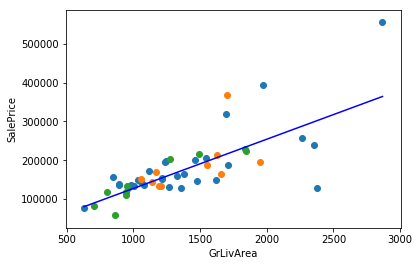

In [278]:
train_sample = housing_price_df[0:1200].sample(30)
val_sample = housing_price_df[1201:1260].sample(10)
test_sample = housing_price_df[1261:1460].sample(10)

x0 = train_sample["GrLivArea"].min()
x1 = train_sample["GrLivArea"].max()

# Retrieve the final weight and bias generated during training.
weight = model.get_variable_value('linear/linear_model/GrLivArea/weights')[0]
bias = model.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted SalePrice for the min and max GrLivArea values.
y0 = weight * x0 + bias 
y1 = weight * x1 + bias

plt.plot([x0, x1], [y0, y1], c='b')

plt.ylabel("SalePrice")
plt.xlabel("GrLivArea")

plt.scatter(train_sample["GrLivArea"], train_sample["SalePrice"])
plt.scatter(val_sample["GrLivArea"], val_sample["SalePrice"])
plt.scatter(test_sample["GrLivArea"], test_sample["SalePrice"])

plt.show();